# Procesiranje slik za meritve v eksperimentalni modalni analizi

---

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Slikovne-meritve" data-toc-modified-id="Slikovne-meritve-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Slikovne meritve</a></span><ul class="toc-item"><li><span><a href="#Parametri-zajema" data-toc-modified-id="Parametri-zajema-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Parametri zajema</a></span></li><li><span><a href="#Osvetlitev" data-toc-modified-id="Osvetlitev-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Osvetlitev</a></span></li><li><span><a href="#Priprava-površine-merjenca" data-toc-modified-id="Priprava-površine-merjenca-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Priprava površine merjenca</a></span></li><li><span><a href="#Pogoste-težave-pri-slikovnih-meritvah" data-toc-modified-id="Pogoste-težave-pri-slikovnih-meritvah-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Pogoste težave pri slikovnih meritvah</a></span><ul class="toc-item"><li><span><a href="#Neustrezno-izostrena-slika" data-toc-modified-id="Neustrezno-izostrena-slika-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Neustrezno izostrena slika</a></span></li><li><span><a href="#Neustrezna-osvetlitev" data-toc-modified-id="Neustrezna-osvetlitev-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Neustrezna osvetlitev</a></span></li></ul></li></ul></li><li><span><a href="#Določitev-pomikov-na-slikah-z-metodo-optičnega-toka-(Simplified-Optical-Flow)" data-toc-modified-id="Določitev-pomikov-na-slikah-z-metodo-optičnega-toka-(Simplified-Optical-Flow)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Določitev pomikov na slikah z metodo optičnega toka (<em>Simplified Optical Flow</em>)</a></span></li><li><span><a href="#Metoda-Lucas-Kanade:" data-toc-modified-id="Metoda-Lucas-Kanade:-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Metoda Lucas-Kanade:</a></span></li><li><span><a href="#Izračun-FRF" data-toc-modified-id="Izračun-FRF-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Izračun FRF</a></span></li><li><span><a href="#Eskperimentalna-modalna-analiza-(samo-slikovn-meritev):" data-toc-modified-id="Eskperimentalna-modalna-analiza-(samo-slikovn-meritev):-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Eskperimentalna modalna analiza (samo slikovn meritev):</a></span></li><li><span><a href="#Eskperimentalna-modalna-analiza---hibridna-metoda" data-toc-modified-id="Eskperimentalna-modalna-analiza---hibridna-metoda-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Eskperimentalna modalna analiza - hibridna metoda</a></span></li></ul></div>

V tej predstavitvi so uporabljeni naslednji paketi:
* ``pip install lvm_read``
* ``pip install pyFRF``
* ``pip install pyidi``
* ``pip install pyEMA``

Priprava paketov in nekaterih funkcij:

In [1]:
import os
import numpy as np
import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from ipywidgets import interact
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import warnings
warnings.filterwarnings('ignore')

import lvm_read
import pyFRF
import pyidi
import pyEMA

C:\Users\Domen\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\distutils\ccompiler.py:17: DeprecationWarning: The distutils.sysconfig module is deprecated, use sysconfig instead
  from distutils.sysconfig import customize_compiler
C:\Users\Domen\AppData\Local\Programs\Python\Python310\lib\site-packages\pyEMA\__init__.py:12: UserWarning: This is the last version of pyEMA and will not longer be maintained since it is moving to the SDyPy package. To use the latest code from SDyPy: `pip install sdypy` and `from sdypy import EMA`.
  warnings.warn('This is the last version of pyEMA and will not longer be maintained since it is moving to the SDyPy package. To use the latest code from SDyPy: `pip install sdypy` and `from sdypy import EMA`.')


In [2]:
%matplotlib inline

font_size = 15
fig_size = (16.0, 8.0)

plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = fig_size
matplotlib.rcParams['font.size'] = font_size


def show_modal_data(nat_freq, damping):
    """Show modal data in a table-like structure."""
    print('   Nat. f.      Damping')
    print(23*'-')
    for i, f in enumerate(nat_freq):
        print(f'{i+1}) {f:6.1f}\t{damping[i]:5.4f}')
        

def plot_mode_shape(shape, axis, style='o-', frequency=None, **kwargs):
    """Plot a mode shape in a consistent fashion."""
    plot = axis.plot(shape / np.max(np.abs(shape)) * np.sign(shape[0]), 
                     style, **kwargs)
    if frequency is not None:
        axis.set_title(f'Mode shape - {frequency:.0f} Hz')
    axis.set_yticks([])
    plt.tight_layout()

## Slikovne meritve

**Postavitev eksperimenta:**

<img src="figures/experiment_setup.jpg" width="80%">

**Vzbujanje z modalnim kladivom:**

<video controls loop src="figures/experiment.mp4" width="100%" rotate="270deg"/>

Datoteke s slikami:

In [5]:
cam_fname = 'data/camera.cih'
lvm_fname = 'data/acceleration.lvm'

Odpiranje posnetka s paketom [pyidi][1]:

[1]: https://github.com/ladisk/pyidi

In [6]:
video = pyidi.pyIDI(cam_fname)

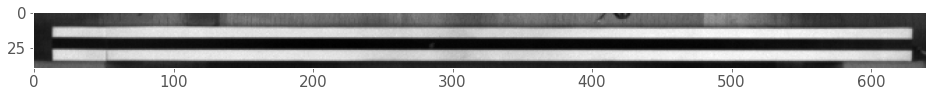

In [7]:
sequential_image_nr = 200
plt.imshow(video.mraw[sequential_image_nr], cmap='gray')
plt.grid(False)

*Posnetek je prilagojen prikazu in je zato slabše kavlaitete. Za natančne meritve običajno zajamemo zel oveliko količino podatkov.*

<video controls loop src="figures/video.MOV" width="950" rotate="270deg"/>

### Parametri zajema

Parametri nastavitve kamere so zapisani v atributu `info`:

In [8]:
video.info

{'Date': '2018/12/17',
 'Time': '12:48',
 'Camera Type': 'FASTCAM SA-Z type 2100K-M-64GB',
 'Head Type': 'Unknown Child Device',
 'Camera ID': 11,
 'Camera Number': 0,
 'Head Number': 1,
 'Max Head Number': 1,
 'Scene Name': '',
 'User Defined Camera Name': '',
 'Session Number': '',
 'Date Record': 'Unknown',
 'Time Record': 'Unknown',
 'Trigger Time': 0,
 'Record Rate(fps)': 15000,
 'Shutter Speed(s)': '1/15371',
 'Trigger Mode': 'Start',
 'Original Total Frame': 7500,
 'Total Frame': 3750,
 'Start Frame': 0,
 'Correct Trigger Frame': 0,
 'Save Step': 1,
 'Image Width': 640,
 'Image Height': 40,
 'Color Type': 'Mono',
 'Color Bit': 8,
 'File Format': 'MRaw',
 'EffectiveBit Depth': 12,
 'EffectiveBit Side': 'Higher',
 'Digits Of File Number': 6,
 'Device Last Error': '-1:0xffffffff',
 'Comment Text': '',
 'AnalogBoard Channel Num': 0,
 'Zero Frame': 'Exist',
 'Shutter Type2(nsec)': 65060,
 'Edge Enhance': 0,
 'Pre LUT Mode': 'DEF1',
 'Pre LUT Brightness': 0,
 'Pre LUT Contrast': 0,
 '

### Osvetlitev

Ustrezna osvetlitev je eden najpomembnejših parametrov pri zajemu slik s hitro kamero.

Pri oceni ustreznosti osvetlitve si lahko pomagamo s hitrogramom sivinskih vrendosti:

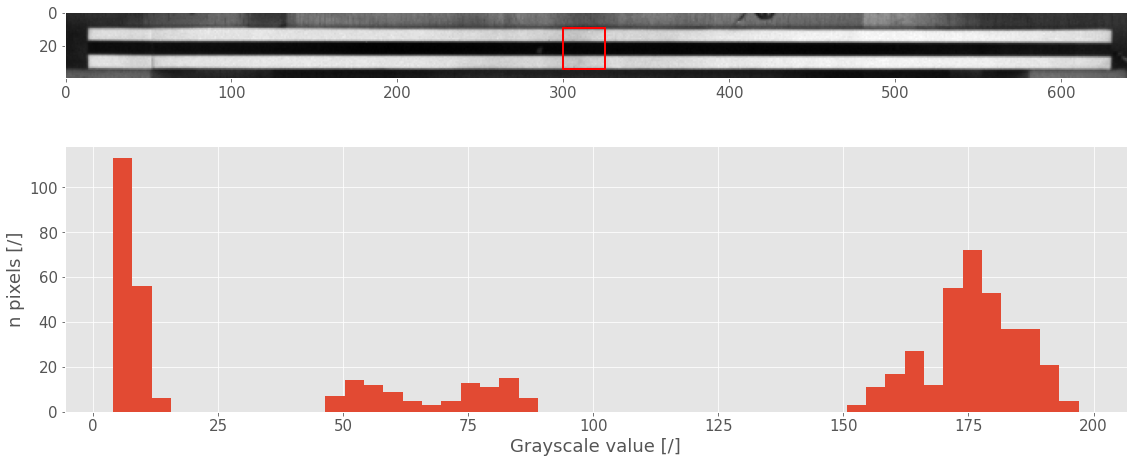

In [9]:
selected_frame = 0
x0 = 300 # position of observed rectangle
y0 = 9
d = 25
roi = video.mraw[selected_frame, y0:y0+d, x0:x0+d]

fig, ax = plt.subplots(2)
ax[0].imshow(video.mraw[selected_frame], cmap='gray')
ax[1].hist(roi.flatten(), bins=50);
# Formating
ax[0].add_patch(patches.Rectangle((x0, y0), d, d, fill=False, color='r', linewidth=2))
ax[0].grid(False)
ax[1].set_xlabel('Grayscale value [/]')
ax[1].set_ylabel('n pixels [/]')
plt.tight_layout()

### Priprava površine merjenca

Za delovanje metod določanja pomikov s slik na osnovi gradientov sivinskih vrendosti je nujno, da je površina merjenca ustrezno pripravljena. 

Pogosto na opazovano površino apliciramo visokokontrasntni vzorec pack (*speckle*) ali črt. Identifikacija pomikov je najzaneslivejša v smeri gradienta sivinskih vrendosti.

In [11]:
grad0, grad1 = np.gradient(video.mraw[0].astype(float)) # gradient computation

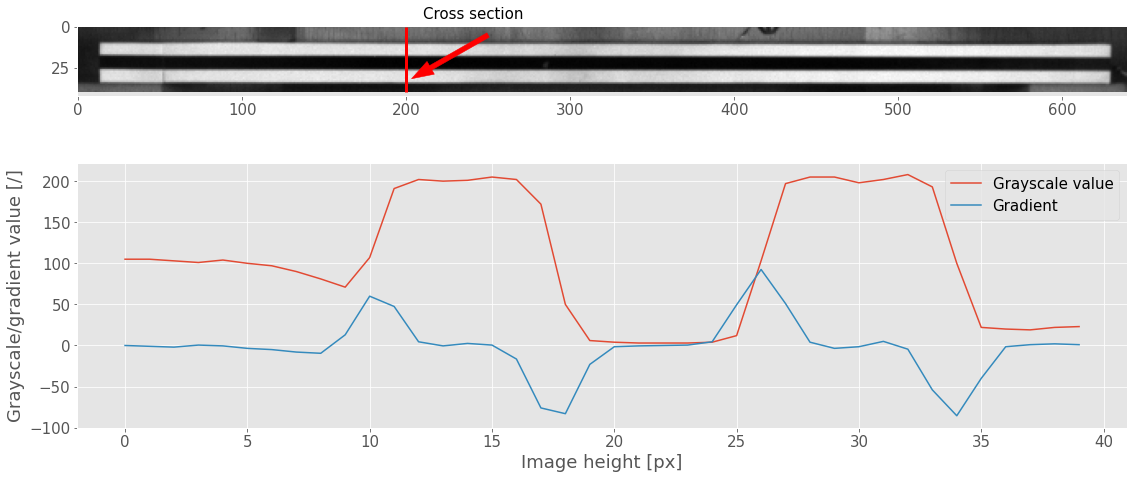

In [12]:
x0 = 200 # position of cross section

fig, ax = plt.subplots(2)
ax[0].imshow(video.mraw[selected_frame], cmap='gray')
ax[1].plot(video.mraw[selected_frame, :, x0], label='Grayscale value')
ax[1].plot(grad0[:, x0], label='Gradient')
# Formating
ax[0].vlines(x0, 0, 40, colors='r', linewidth=3)
ax[0].text(x0+10, -5, 'Cross section')
ax[0].arrow(x0+50, 5, -35, 20, color='r', width=3)
ax[0].grid(False)
ax[1].set_xlabel('Image height [px]')
ax[1].set_ylabel('Grayscale/gradient value [/]')
plt.legend()
plt.tight_layout()

### Pogoste težave pri slikovnih meritvah

#### Neustrezno izostrena slika

In [13]:
layout_fname = r'data/focus.cih'
video_layout = pyidi.pyIDI(layout_fname)

C:\Users\Domen\AppData\Local\Programs\Python\Python310\lib\site-packages\pyMRAW.py:91: UserWarning: Not 12bit (8 bits)! clipped values?
  warnings.warn('Not 12bit ({:g} bits)! clipped values?'.format(bits))
C:\Users\Domen\AppData\Local\Programs\Python\Python310\lib\site-packages\pyMRAW.py:103: UserWarning: Clipped footage! (Total frame: 1, Original total frame: 44)
  warnings.warn('Clipped footage! (Total frame: {}, Original total frame: {})'.format(cih['Total Frame'], cih['Original Total Frame'] ))


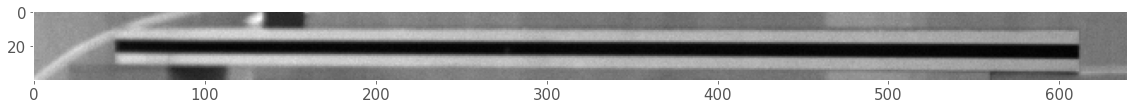

In [14]:
fig, ax = plt.subplots()
ax.imshow(video_layout.mraw[0], 'gray')

# Formating
ax.grid(False)
plt.tight_layout()

#### Neustrezna osvetlitev

In [15]:
light_fname = r'data/illumination.cih'
video_light = pyidi.pyIDI(light_fname)

C:\Users\Domen\AppData\Local\Programs\Python\Python310\lib\site-packages\pyMRAW.py:103: UserWarning: Clipped footage! (Total frame: 1, Original total frame: 34)
  warnings.warn('Clipped footage! (Total frame: {}, Original total frame: {})'.format(cih['Total Frame'], cih['Original Total Frame'] ))


In [16]:
selected_frame = 0
y0, d = 9, 20

def show(x0):
    roi = video_light.mraw[selected_frame, y0:y0+d, x0:x0+d*2]
    fig, ax = plt.subplots(2)
    ax[0].imshow(video_light.mraw[selected_frame], cmap='gray')
    ax[1].hist(roi.flatten(), bins=50);
    # Formating
    ax[0].add_patch(patches.Rectangle((x0, y0), d*2, d, fill=False, color='r', linewidth=2))
    ax[0].grid(False)
    ax[1].set_xlabel('Grayscale value [/]')
    ax[1].set_ylabel('n pixels [/]')
    ax[1].set_xlim([0, 260])
    plt.tight_layout()
interact(show, x0=(75, 550, 50));

C:\Users\Domen\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\pylab\backend_inline.py:11: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  warnings.warn(


interactive(children=(IntSlider(value=275, description='x0', max=550, min=75, step=50), Output()), _dom_classe…

---

## Določitev pomikov na slikah z metodo optičnega toka

Svetlost na sliki se ohranja:
$$
	f(x, y, t) = f(x + \Delta x, y + \Delta y, t+ \Delta t).
$$

Sledi enačba poenostavljene metode optičnega toka za posamezno točko na sliki:
$$
s(x_j,y_k,t)=\frac{f_0(x_j,y_k)-f(x_j,y_k,t)}{|\nabla f_0|}
$$

$s(x_j,y_k,t) \dots$ pomik točke v smeri lokalnega gadienta sivinskih vrednosti

([Javh et al][1])

[1]: http://lab.fs.uni-lj.si/ladisk/?what=abstract&ID=179

Računamo pomike glede na refernčno sliko:

In [17]:
reference_image = np.average(video.mraw[:10], axis=0)

Potrebujemo slike gradienta v smeri ``x`` (1) in ``y`` (0):

In [18]:
grad0, grad1 = np.gradient(reference_image)

In [19]:
G = np.sqrt(grad0**2 + grad1**2)

Za obdelavo so primerne točke z visoko vrednostjo gradienta:

In [21]:
border = 20
border_h = 12
n = 2
N = 16
w = np.arange(border, reference_image.shape[1]-border, np.abs(border - reference_image.shape[1]-border)//N)
h = np.argsort(np.abs(grad0[border_h:-border_h, w]), axis=0)[-n:, :].T + border_h
inds = np.column_stack((h.flatten(), w.repeat(n)))

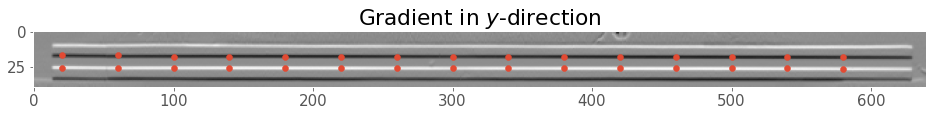

In [22]:
fig, ax = plt.subplots()
ax.imshow(grad0, cmap='gray')
ax.scatter(inds[:, 1], inds[:, 0])
ax.grid(False)
ax.set_title('Gradient in $y$-direction');

Enačba optičnega toka:

In [23]:
d_of = ((reference_image[inds.T[0], inds.T[1]] - video.mraw[:, inds.T[0], inds.T[1]]) / np.abs(G[inds.T[0], inds.T[1]])).T
d_of.shape

(30, 3750)

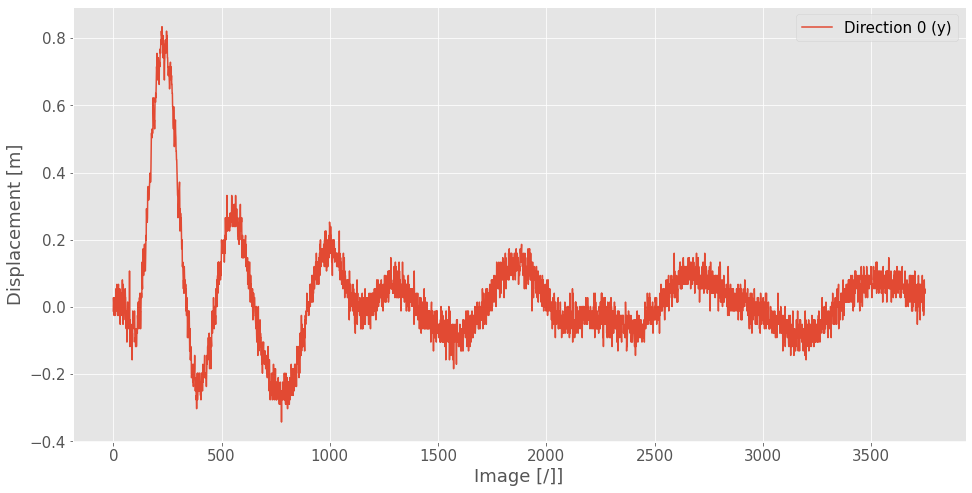

In [25]:
fig, ax = plt.subplots()
ax.plot(d_of[0], label='Direction 0 (y)');
ax.set_xlabel('Image [/]]')
ax.set_ylabel('Displacement [m]')
plt.legend()

Izračun pomikov s ``pyidi``:

In [26]:
video.set_points(points=inds) # izbira točk za analizo

In [27]:
video.set_method(method='sof',
                mean_n_neighbours=n)

Izračun pomikov z ``get_displacements()``:

In [28]:
displacements = video.get_displacements() * 8e-5

100%|██████████████████████████████████████████████████████████| 3750/3750 [00:07<00:00, 478.55it/s]

Averaging...
Finished!



C:\Users\Domen\AppData\Local\Programs\Python\Python310\lib\site-packages\pyidi\methods\_simplified_optical_flow.py:138: UserWarning: Displacement larger than 0.5 pixel
  warnings.warn('Displacement larger than 0.5 pixel')


In [29]:
location = 1

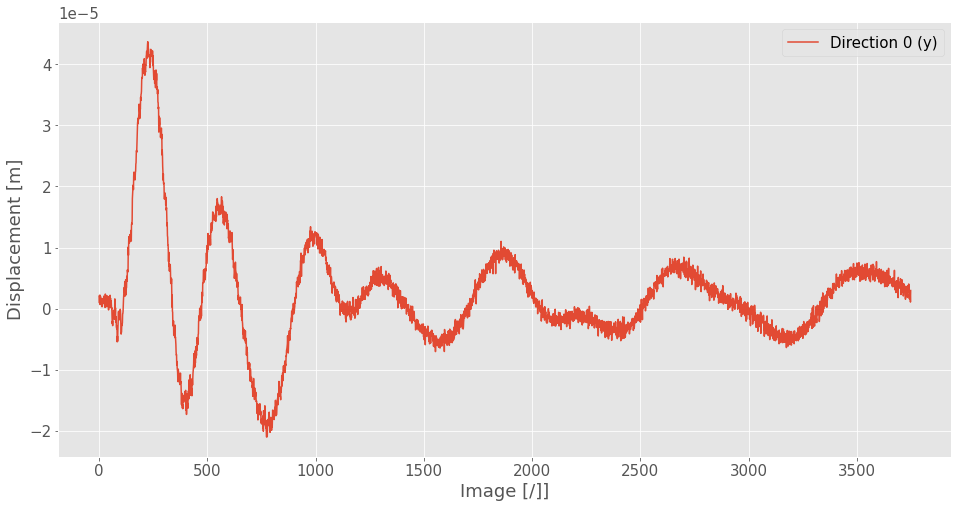

In [30]:
fig, ax = plt.subplots()
ax.plot(displacements[location, :, 0], label='Direction 0 (y)');
ax.set_xlabel('Image [/]]')
ax.set_ylabel('Displacement [m]')
plt.legend()

## Metoda Lucas-Kanade:

Če enačbe optičnega toka zapišemo za podobmočje več točk na sliki, dobimo predoločen sistem enačb.

Rešitev predoločenega sistema v smislu najmanjše kvadratične napake nam da pomik podobmočja:

$$
\begin{equation}
	\begin{bmatrix}
		\Delta x \\
		\Delta y
	\end{bmatrix} =
	\begin{bmatrix}
		\sum g_x^2 &\sum  g_x \, g_y \\
		\sum  g_x \, g_y &\sum g_y^2
	\end{bmatrix}^{-1}
	\begin{bmatrix}
		\sum g_x \, (f-g) \\
		\sum g_y \, (f-g)
	\end{bmatrix}
\end{equation}
$$


$f(\mathbf{x}) \dots$ trenutna (premaknjena) slika

$g(\mathbf{x}) \dots$ referenčna slika

Do enake rešitve pridemo, če rešim opzimizacijski problem, v katerem iščemo parametre $\Delta \mathbf{x}$, ki premaknjeno trenutno sliko $f(\mathbf{x} + \Delta \mathbf{x})$ poravnajo z referenčno $g(\mathbf{x})$:

$$
SSD(\Delta \mathbf{x}) = \sum\limits_{x, y} \big[f(\mathbf{x} + \Delta \mathbf{x}) - g(\mathbf{x})\big]^2.
$$


In [31]:
points_lk = np.column_stack([np.ones_like(w)*video.info['Image Height']//2, w])

In [35]:
video.set_points(points_lk)
video.set_method('lk', roi_size=(21, 23), max_nfev=10, int_order=3)

In [36]:
points_lk.shape

(15, 2)

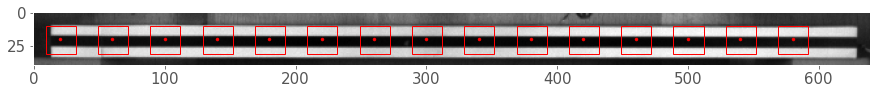

In [37]:
video.show_points()

Izrčaun pomikov:

In [38]:
displacements_lk = video.get_displacements(processes=2) * 8e-5

--- Starting new analysis ---
 
Computation start: 2022-05-31 09:17:18.199292


C:\Users\Domen\AppData\Local\Programs\Python\Python310\lib\site-packages\pyidi\methods\_lucas_kanade.py:464: ResourceWarning: unclosed file <_io.BufferedWriter name='data\\temp_file\\settings.pkl'>
  pickle.dump(settings, open(self.settings_filename, 'wb'))
C:\Users\Domen\AppData\Local\Programs\Python\Python310\lib\site-packages\pyidi\methods\_lucas_kanade.py:466: ResourceWarning: unclosed file <_io.BufferedWriter name='data\\temp_file\\points.pkl'>
  pickle.dump(self.video.points, open(self.points_filename, 'wb'))


VBox()

Computation duration: 00:01:45.95
data\camera_pyidi_analysis\analysis_001\ analysis_001


sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1ec65ccb160>
C:\Users\Domen\AppData\Local\Programs\Python\Python310\lib\site-packages\pyidi\pyidi.py:225: ResourceWarning: unclosed file <_io.BufferedWriter name='data\\camera_pyidi_analysis\\analysis_002\\results.pkl'>
  pickle.dump(self.displacements, open(os.path.join(root, 'results.pkl'), 'wb'), protocol=-1)
C:\Users\Domen\AppData\Local\Programs\Python\Python310\lib\site-packages\pyidi\pyidi.py:226: ResourceWarning: unclosed file <_io.BufferedWriter name='data\\camera_pyidi_analysis\\analysis_002\\points.pkl'>
  pickle.dump(self.points, open(os.path.join(root, 'points.pkl'), 'wb'), protocol=-1)


In [ ]:
#displacements_lk = np.load('data/displacements_lk.npy')

In [39]:
točka = 1

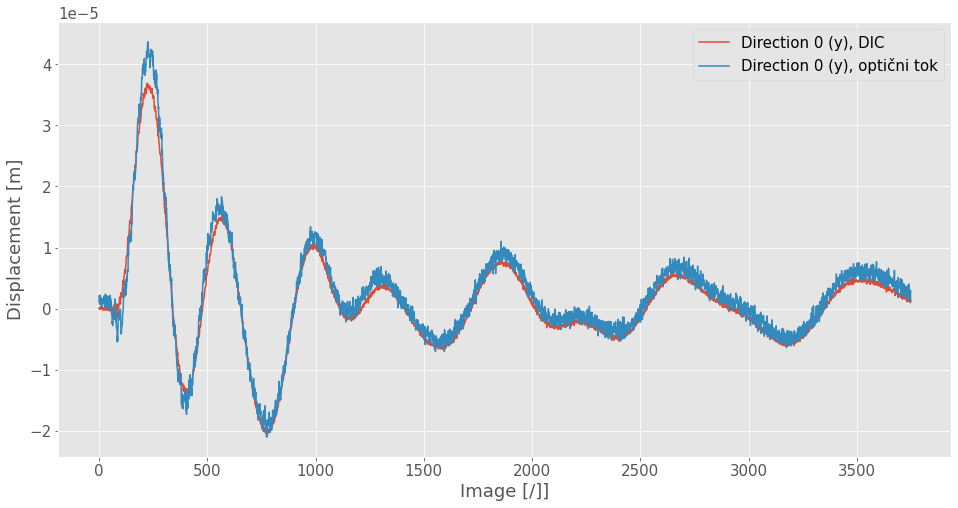

In [41]:
fig, ax = plt.subplots()
ax.plot(displacements_lk[3, :, 0], label='Direction 0 (y), DIC')
ax.plot(displacements[location, :, 0], label='Direction 0 (y), optični tok');
ax.set_xlabel('Image [/]]')
ax.set_ylabel('Displacement [m]')
plt.legend()

In [42]:
displacements = displacements_lk

## Izračun FRF

Izračun amplitudnih spektrov pomikov:

In [43]:
N = int(video.info['Total Frame'])
dt = 1/int(video.info['Record Rate(fps)'])
1/dt

15000.0

In [44]:
T = dt*N
T

0.25

In [45]:
upper_f_limit = 4000 # zgornja frekvenčna meja, ki nas zanima

In [46]:
freq_cam = np.fft.rfftfreq(N, dt)
fft_cam = np.fft.rfft(displacements[:, :, 0], N) * 2 / N 

Opazujemo le frekvence pod mejo `upper_f_limit` Hz:

In [47]:
fft_cam = np.copy(fft_cam[:, freq_cam<upper_f_limit])
freq_cam = np.copy(freq_cam[freq_cam<upper_f_limit])

Silo vzbujanja smo merili s silomerom.

Da lahko meritiv kombiniaramo, je pomembna **ujemajoča frekvenčna ločljivost**! Tudi tukaj se omejimo do `upper_f_limit`:

In [48]:
lvm = lvm_read.read(lvm_fname)
force = lvm[0]['data'][:-30, 1] # 30 predvzorcev
N = len(force)//4 # dolžina shranjenega videa je 0.25 s
dt = lvm[0]['Delta_X'][1]

fft_force = np.fft.rfft(force, N) *2/N
freq_force = np.fft.rfftfreq(N, dt)

fft_force = np.copy(fft_force[freq_force<upper_f_limit])
freq_force = np.copy(freq_force[freq_force<upper_f_limit])

Ker smo zajeli le en segment ne moremo uporabiti natančnejše cneilke FRF:

In [49]:
frf_cam = fft_cam/fft_force 

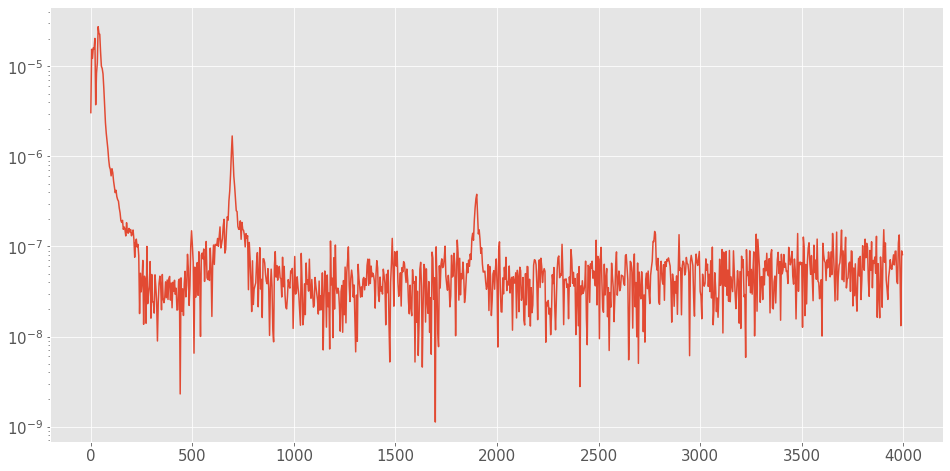

In [50]:
plt.semilogy(freq_cam, np.abs(frf_cam[točka]));

## Eskperimentalna modalna analiza (samo slikovna meritev):

Za eksperimentalno modalnoa analizo uporabimo paket [``pyEMA``][1].

[1]: https://pypi.org/project/pyEMA/

In [51]:
cam = pyEMA.Model(frf_cam, freq_cam, pol_order_high=50, upper=upper_f_limit)

Izračun polov modela frekvenčne prenosne funkcije:

In [52]:
cam.get_poles(show_progress=True)

100%|███████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 35.75it/s]


Izbrati moramo pole, ki se zdijo fizikalno smiselni (stabilni).

In [53]:
cam.stab_chart(cam.all_poles)

C:\Users\Domen\AppData\Local\Programs\Python\Python310\lib\site-packages\pyEMA\pyEMA.py:311: UserWarning: `stab_chart()` method is deprecated. Please use the `select_poles()` method.
  warnings.warn('`stab_chart()` method is deprecated. Please use the `select_poles()` method.')
100%|██████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 150.28it/s]


SHIFT + LEFT mouse button to pick a pole.
SHIFT + RIGHT mouse button to erase the last pick.
1. Frequency: ~691 -->	695.0653446992449 Hz	(xi = -0.0023)
2. Frequency: ~1887 -->	1897.4506429927983 Hz	(xi = -0.0016)
3. Frequency: ~2464 -->	2467.906640957225 Hz	(xi = -0.0093)


<Figure size 1152x576 with 0 Axes>

In [54]:
cam.print_modal_data()

   Nat. f.      Damping
-----------------------
1)  695.1	-0.0023
2) 1897.5	-0.0016
3) 2467.9	-0.0093


Za rekonstrukcijo modela FRF uporabimo metodo LSFD:

In [55]:
frf_rec, shapes_cam = cam.get_constants(FRF_ind='all')

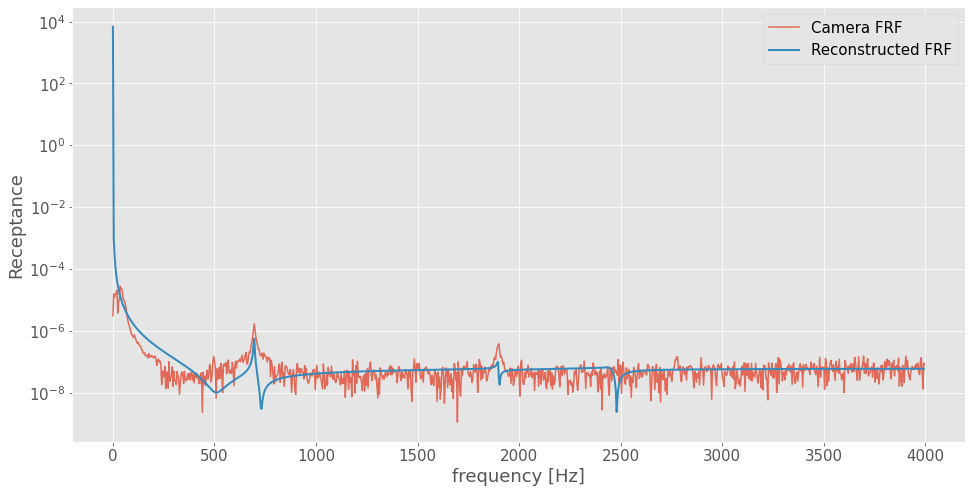

In [56]:
fig, ax = plt.subplots()
ax.semilogy(freq_cam, np.abs(frf_cam[točka]), label='Camera FRF', alpha=0.8)
ax.semilogy(freq_cam[:-1], np.abs(frf_rec[točka]), label='Reconstructed FRF', lw=2)
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('Receptance')
plt.legend();

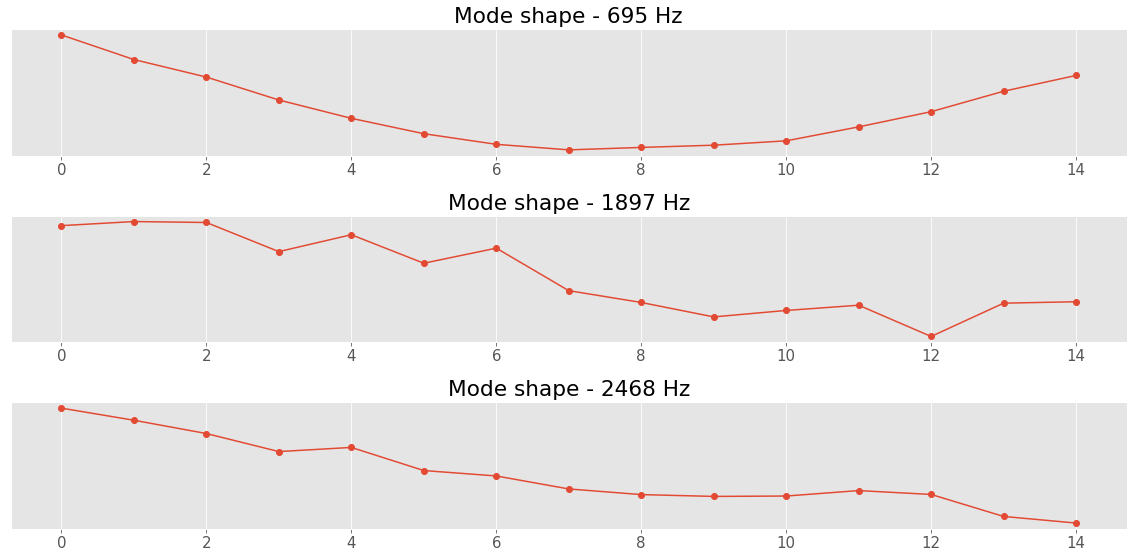

In [57]:
fig, ax = plt.subplots(shapes_cam.shape[1])
for i, a in enumerate(ax):
    plot_mode_shape(shapes_cam[:, i], axis=a, frequency=cam.nat_freq[i])

## Eskperimentalna modalna analiza - hibridna metoda

Pri hibridni metodi kombiniramo pomike s slik z visoko prostorsko ločljivostjo in meritve pospeška z visoko natančnostjo:

In [59]:
hyb_acc = lvm[0]['data'][:-30, 0] * 9.81 # pospeškomer

Za oceno FRF lahk uporabimo paket [``pyFRF``][1]

[1]: https://pypi.org/project/pyFRF/

In [60]:
import pyFRF

frf_ = pyFRF.FRF(
    sampling_freq=1/dt,
    exc=force,
    resp=hyb_acc,
    exc_window='None',
    resp_type='a',
    resp_window='None')

C:\Users\Domen\AppData\Local\Programs\Python\Python310\lib\site-packages\pyFRF.py:173: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.curr_meas = np.int(0)


Opazujemo le frekvenčno območj do `upper_f_limit` Hz:

In [62]:
freq_acc = frf_.get_f_axis()
frf_acc = frf_.get_FRF(form='receptance')

frf_acc = frf_acc[freq_acc<upper_f_limit]
freq_acc = freq_acc[freq_acc<upper_f_limit]

Pospeškomer je bil nameščen v točki z indeksom 3:

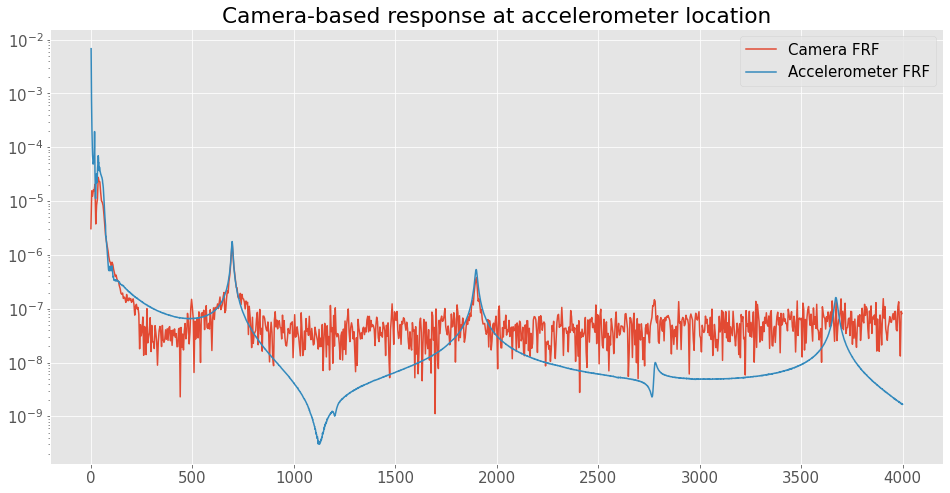

In [63]:
fig, ax = plt.subplots()
ax.semilogy(freq_cam, np.abs(frf_cam[točka]), label='Camera FRF')
ax.semilogy(freq_acc, np.abs(frf_acc), label='Accelerometer FRF')
ax.set_title('Camera-based response at accelerometer location')
plt.legend();

Poli modela FRF so izrčaunani s hibridno metodo na podlagi meritev pospeška:

In [64]:
acc = pyEMA.Model(frf_acc[1:], freq_acc[1:], pol_order_high=50, upper=upper_f_limit)

In [65]:
acc.get_poles(show_progress=True)

100%|███████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 35.33it/s]


In [66]:
acc.stab_chart(acc.all_poles)

C:\Users\Domen\AppData\Local\Programs\Python\Python310\lib\site-packages\pyEMA\pyEMA.py:311: UserWarning: `stab_chart()` method is deprecated. Please use the `select_poles()` method.
  warnings.warn('`stab_chart()` method is deprecated. Please use the `select_poles()` method.')
100%|██████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 103.18it/s]


SHIFT + LEFT mouse button to pick a pole.
SHIFT + RIGHT mouse button to erase the last pick.
1. Frequency: ~719 -->	694.9558637688194 Hz	(xi = 0.0047)
2. Frequency: ~1891 -->	1897.5325587429413 Hz	(xi = 0.0031)
3. Frequency: ~2772 -->	2777.3298298887007 Hz	(xi = 0.0024)
4. Frequency: ~3681 -->	3671.181158516763 Hz	(xi = 0.0020)


<Figure size 1152x576 with 0 Axes>

In [67]:
acc.print_modal_data()

   Nat. f.      Damping
-----------------------
1)  695.0	0.0047
2) 1897.5	0.0031
3) 2777.3	0.0024
4) 3671.2	0.0020


Poli, izračunani na podlagi pospeškov, so zanesljivejši. TUporabimo jih pri rekonstrukciji FRF s pomiki, pomerjen s kamero.

In [68]:
cam_hyb = pyEMA.Model(frf_cam, freq_cam)

Rekonstrukcijo naredimo z uporabo polov iz pospeškomera:

In [69]:
frf_hyb, shapes_hybrid = cam_hyb.get_constants(whose_poles=acc)

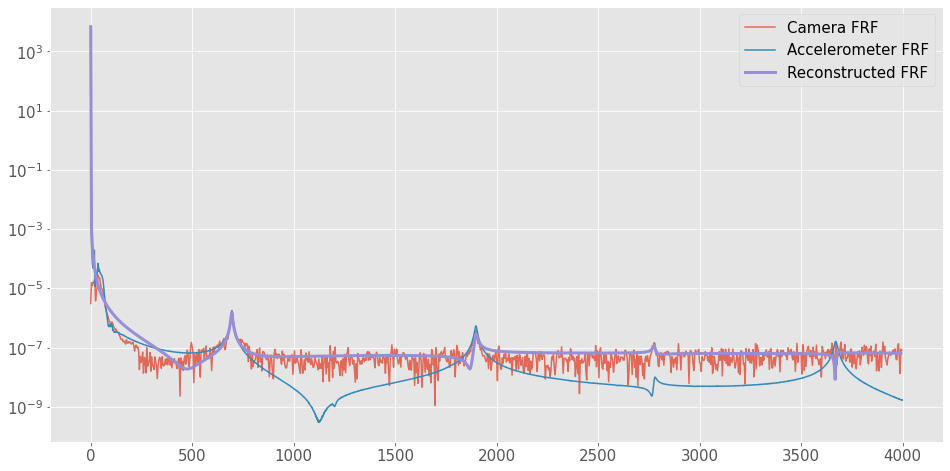

In [70]:
fig, ax = plt.subplots()
ax.semilogy(freq_cam, np.abs(frf_cam[točka]), label='Camera FRF', alpha=0.8)
ax.semilogy(freq_acc, np.abs(frf_acc), label='Accelerometer FRF')
ax.semilogy(freq_cam[:-1], np.abs(frf_hyb[točka]), label='Reconstructed FRF', lw=3)
plt.legend();

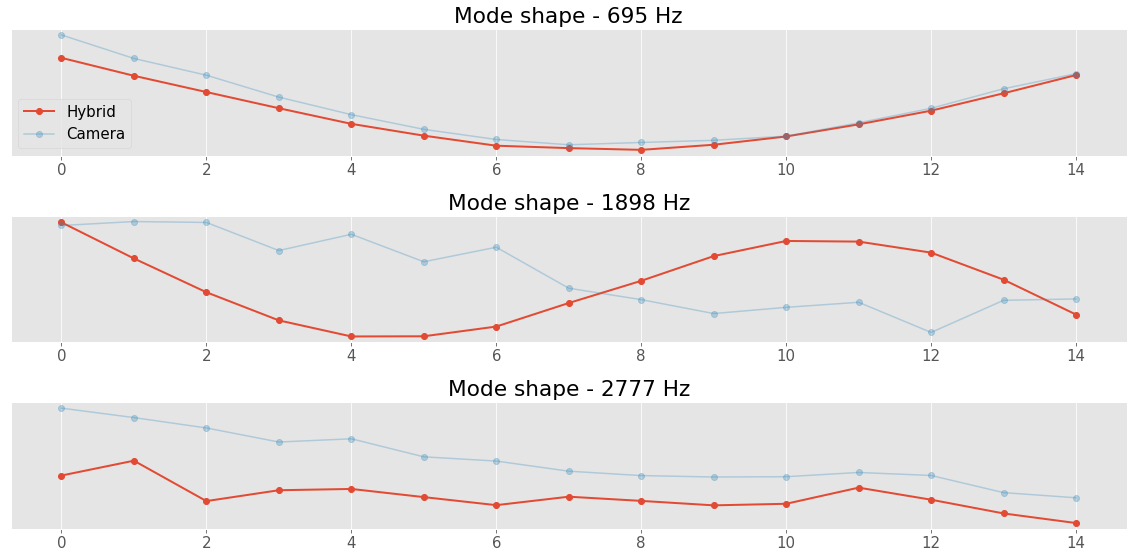

In [71]:
fig, ax = plt.subplots(shapes_cam.shape[-1])
for i, a in enumerate(ax):
    cam_freq = cam.nat_freq[i]
    hybrid_f_index = np.argmin(np.abs(acc.nat_freq - cam_freq))
    plot_mode_shape(shapes_hybrid[:, hybrid_f_index], axis=a, 
                    frequency=acc.nat_freq[hybrid_f_index], lw=2, label='Hybrid')
    plot_mode_shape(shapes_cam[:, i], axis=a , alpha=0.3, label='Camera')
    a.set_yticks([])
ax[0].legend()

Na ta način smo pri stabilizaciji zaznali dodatno lasnto obliko:

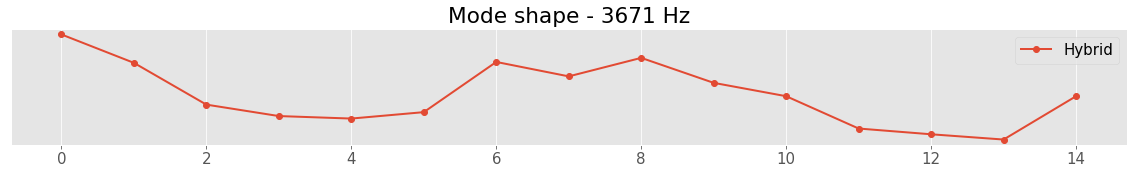

In [72]:
plt.figure(figsize=(fig_size[0], fig_size[1]/3))
plot_mode_shape(shapes_hybrid[:, -1], axis=plt.gca(), 
                frequency=acc.nat_freq[-1], lw=2, label='Hybrid')
plt.legend()